![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/SparkOCRVisualDocumentNer.ipynb)

# Visual Document Ner

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

## Attention! Restart kernel after first run in order to use newly installed versions of some libraries.

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

from sparkocr.transformers import ImageToHocr, VisualDocumentNer, BinaryToImage
from sparkocr.utils import display_image, display_images

# import sparknlp packages
from sparknlp.annotator import *
from sparknlp.base import *

### Initialize Spark session

In [3]:
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



In [4]:
pretrained_model = ("visual_document_NER_SROIE0526", "en", "public/ocr/models")

## Load test images

In [5]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/SROIE/')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/usr/local/l...|2022-01-10 18:01:...|3378240|[FF D8 FF E0 00 1...|
+--------------------+--------------------+-------+--------------------+



## Display images


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/SROIE/a05023.jpeg
    Resolution: 0 dpi
    Width: 4961 px
    Height: 7016 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


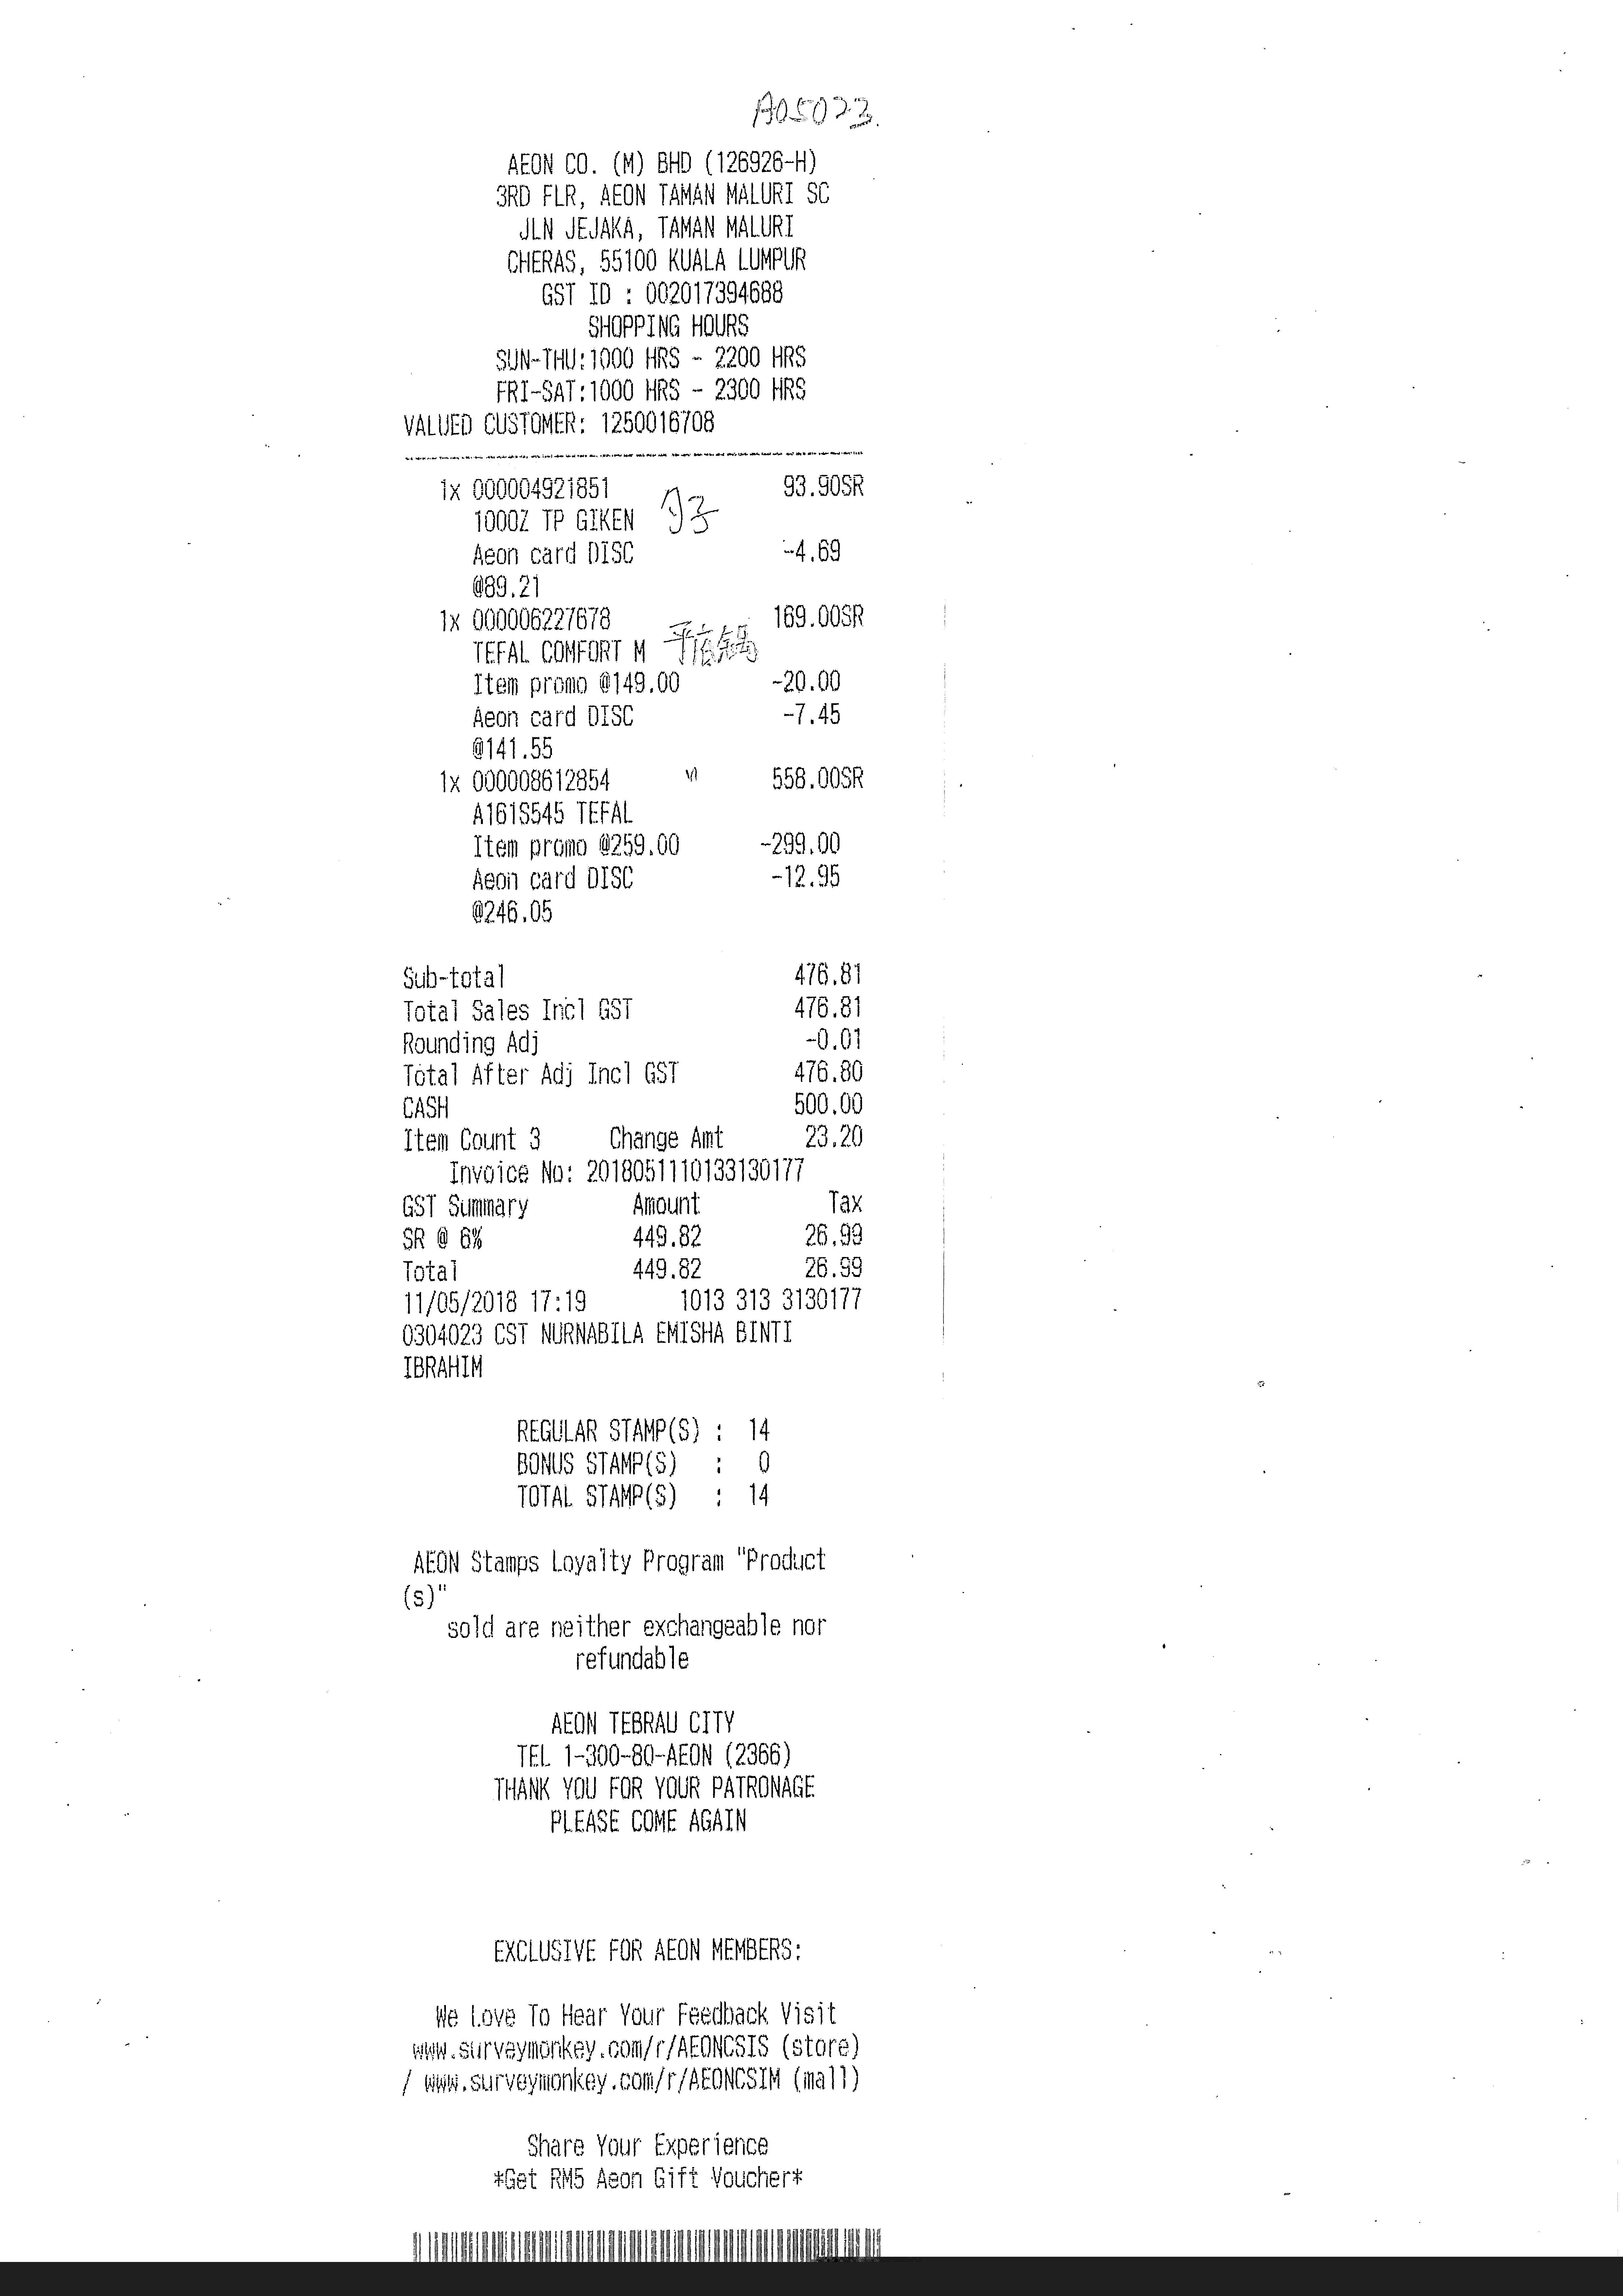

In [6]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [7]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image")

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

doc_ner = VisualDocumentNer()\
    .pretrained(*pretrained_model)\
    .setInputCol("hocr")    

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    doc_ner
])

visual_document_NER_SROIE0526 download started this may take some time.
Approximate size to download 396 MB


## Call pipeline

In [8]:
results = pipeline.transform(bin_df).cache()

## Show results

In [11]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = F.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", F.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
    .withColumn("exploded_entities", F.explode("entities")) \
    .select("filename", "exploded_entities") \
    .filter(F.col("exploded_entities").result != 'O') \
    .show(truncate=False)
            

+-----------+--------------------------------------------------------------------------------------------------------------------+
|filename   |exploded_entities                                                                                                   |
+-----------+--------------------------------------------------------------------------------------------------------------------+
|a05023.jpeg|[entity, 9, 12, B-COMPANY, [x -> 1554, y -> 468, height -> 66, token -> aeon, word -> AEON, width -> 135], []]      |
|a05023.jpeg|[entity, 9, 12, B-COMPANY, [x -> 1554, y -> 468, height -> 66, token -> aeon, word -> AEON, width -> 135], []]      |
|a05023.jpeg|[entity, 14, 15, B-COMPANY, [x -> 1730, y -> 466, height -> 66, token -> co, word -> CO., width -> 91], []]         |
|a05023.jpeg|[entity, 14, 14, B-COMPANY, [x -> 1730, y -> 466, height -> 66, token -> ., word -> CO., width -> 91], []]          |
|a05023.jpeg|[entity, 46, 49, B-COMPANY, [x -> 1836, y -> 561, height -> 68, token 